In [2]:
%matplotlib inline

In [ ]:
#!/usr/bin python2.7

from astropy.io       import fits
from astropy.table    import Table
from astropy.time     import Time
from datetime         import date
from datetime         import datetime
import ephem
import fileinput
import getpass
import math
import matplotlib.pyplot                   as plt
import matplotlib                          as mpl
import numpy                               as np
from numpy            import linalg        as LA
import os
import pyfits
import scipy.optimize                      as optimization
from scipy            import integrate
from scipy            import interpolate
from scipy.optimize   import curve_fit
import subprocess
from subprocess       import Popen, PIPE
import urllib2
from work_module      import calculate
from work_module      import detector
from work_module      import readfile
from work_module      import writefile
calc = calculate()
det = detector()
rf = readfile()
wf = writefile()

#docstrings of the different self-made classes within the self-made module
#cdoc = calc.__doc__
#ddoc = det.__doc__
#rdoc = rf.__doc__



day = 150926
detector = det.n8
data_type = 'ctime'
year = int('20' + str(day)[0:2])

#get the iso-date-format from the day
date = datetime(year, int(str(day)[2:4]), int(str(day)[4:6]))

#get the ordinal indicator for the date
ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(n/10%10!=1)*(n%10<4)*n%10::4])

#read the measurement data
ctime_data = rf.ctime(detector, day)
echan = ctime_data[0]
total_counts = ctime_data[1]
echan_counts = ctime_data[2]
total_rate = ctime_data[3]
echan_rate = ctime_data[4]
bin_time = ctime_data[5]
good_time = ctime_data[6]
exptime = ctime_data[7]
bin_time_mid = np.array((bin_time[:,0]+bin_time[:,1])/2)

echan = 2 #define which energy-channels one wants to look at
counts = echan_rate[echan]
#counts = total_rate

#read the satellite data
sat_data = rf.poshist_bin(day, bin_time_mid, detector, data_type)
sat_time_bin = sat_data[0]
sat_pos_bin = sat_data[1]
sat_lat_bin = sat_data[2]
sat_lon_bin = sat_data[3]
sat_q_bin = sat_data[4]

#calculate the sun data
sun_data = calc.sun_ang_bin(detector, day, bin_time_mid, data_type)
sun_ang_bin = sun_data[0]
sun_ang_bin = calc.ang_eff(sun_ang_bin, echan)[0]

#calculate the earth data
earth_data = calc.earth_ang_bin(detector, day, bin_time_mid, data_type)
earth_ang_bin = earth_data[0]
earth_ang_bin = calc.ang_eff(earth_ang_bin, echan)[0]
#earth_ang_bin = calc.earth_occ_eff(earth_ang_bin, echan)

#read the SFL data
flares = rf.flares(year)
flares_day = flares[0]
flares_time = flares[1]
if np.any(flares_day == day) == True:
    flares_today = flares_time[:,np.where(flares_day == day)]
    flares_today = np.squeeze(flares_today, axis=(1,))/3600.
else:
    flares_today = np.array(-5)


#periodical function corresponding to the orbital behaviour -> reference day is 150926, periodical shift per day is approximately 0.199*math.pi
sat_time = rf.poshist(day)[0]
'''def j2000_orb(f, g, counts):#J2000-position oriented orbit
    j2000_orb = f*(calc.intpol(np.sin((2*math.pi*np.arange(len(sat_time)))/5531 + g), day, 0, sat_time, bin_time_mid, detector)[0])
    j2000_orb[np.where(counts == 0)] = 0
    return j2000_orb

def geo_orb(g, h, counts):#LON-oriented orbit (earth rotation considered -> orbit within the magnetic field of the earth)
    geo_orb = g*(calc.intpol(np.sin((2*math.pi*np.arange(len(sat_time)))/6120.85 + h), day, 0, sat_time, bin_time_mid, detector)[0])
    geo_orb[np.where(counts == 0)] = 0
    return geo_orb'''#excluded, because their impact on the background is insignificant


#read the magnetic field data
'''magn_data = rf.magfits(day)
t_magn = magn_data[0]
h_magn = magn_data[1]
x_magn = magn_data[2]
y_magn = magn_data[3]
z_magn = magn_data[4]
t_magn = calc.intpol(t_magn, day, 0, sat_time, bin_time_mid)[0]
h_magn = calc.intpol(h_magn, day, 0, sat_time, bin_time_mid)[0]
z_magn = calc.intpol(z_magn, day, 0, sat_time, bin_time_mid)[0]

magnetic = z_magn#define which component of the magnetic field to plot'''

lat_data = rf.mcilwain(day)
mc_b = lat_data[1]
mc_l = lat_data[2]

mc_b = calc.intpol(mc_b, day, 0, sat_time, bin_time_mid)[0]
mc_l = calc.intpol(mc_l, day, 0, sat_time, bin_time_mid)[0]

magnetic = mc_l

#constant function corresponding to the diffuse y-ray background
cgb = np.ones(len(counts))

#counts[120000:] = 0
cgb[np.where(counts == 0)] = 0
earth_ang_bin[np.where(counts == 0)] = 0
sun_ang_bin[np.where(counts == 0)] = 0
magnetic[np.where(counts == 0)] = 0


def fit_function(x, a, b, c, d):
    return a*cgb + b*magnetic + c*earth_ang_bin + d*sun_ang_bin# + j2000_orb(e, f, counts) + geo_orb(g, h, counts)

x0 = np.array([1300., 20, -12, -1])#, 0.5, 0.5, 0.2, -1.3])
sigma = np.array((counts + 1)**(0.5))

fit_results = optimization.curve_fit(fit_function, bin_time_mid, counts, x0, sigma)
coeff = fit_results[0]

print 'CGB coefficient:',coeff[0]
print 'Magnetic field coefficient:',coeff[1]
print 'Earth angle coefficient:',coeff[2]
print 'Sun angle coefficient:',coeff[3]
'''print 'J2000 orbit coefficient & phase:',coeff[4],'&',coeff[5]
print 'Geographical orbit coefficient & phase:',coeff[6],'&',coeff[7]'''
#print np.where(total_counts == 0)
#print bin_time_mid[np.where(total_counts == 0)]
#print sat_time_bin[np.where(total_counts == 0)]
#print bin_time_mid[0]
#print sat_time_bin[0]

a = fit_results[0][0]
b = fit_results[0][1]
c = fit_results[0][2]
d = fit_results[0][3]
'''e = fit_results[0][4]
f = fit_results[0][5]
g = fit_results[0][6]
h = fit_results[0][7]

j2000_orb = j2000_orb(e, f, counts)
geo_orb = geo_orb(g, h, counts)'''

fit_curve = a*cgb + b*magnetic + c*earth_ang_bin + d*sun_ang_bin# + j2000_orb + geo_orb

CGB coefficient: 98.6617800192
Magnetic field coefficient: 53.6045323707
Earth angle coefficient: 0.299738383458
Sun angle coefficient: -0.197176050729


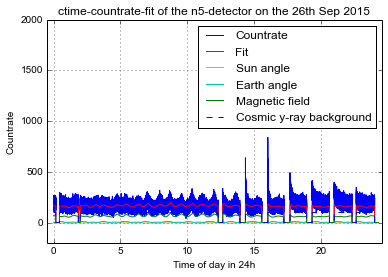

In [5]:

residual_curve = counts - fit_curve






In [ ]:
#####plot-algorhythm#####
#convert the x-axis into hours of the day
plot_time_bin_date = calc.met_to_date(bin_time_mid)[0]
plot_time_bin = (plot_time_bin_date - calc.day_to_met(day)[1])*24#Time of day in hours
plot_time_sat_date = calc.met_to_date(sat_time_bin)[0]
plot_time_sat = (plot_time_sat_date - calc.day_to_met(day)[1])*24#Time of day in hours


###plot each on the same axis as converted to counts###
fig, ax1 = plt.subplots()

plot1 = ax1.plot(plot_time_bin, counts, 'b-', label = 'Countrate')
plot2 = ax1.plot(plot_time_bin, fit_curve, 'r-', label = 'Fit')
plot3 = ax1.plot(plot_time_sat, d*sun_ang_bin, 'y-', label = 'Sun angle')
plot4 = ax1.plot(plot_time_sat, c*earth_ang_bin, 'c-', label = 'Earth angle')
plot5 = ax1.plot(plot_time_sat, b*magnetic, 'g-', label = 'Magnetic field')
plot6 = ax1.plot(plot_time_sat, a*cgb, 'b--', label = 'Cosmic y-ray background')
#plot7 = ax1.plot(plot_time_sat, j2000_orb, 'y--', label = 'J2000 orbit')
#plot8 = ax1.plot(plot_time_sat, geo_orb, 'g--', label = 'Geographical orbit')

#plot vertical lines for the solar flares of the day
if np.all(flares_today != -5):
    if len(flares_today[0]) > 1:
        for i in range(0, len(flares_today[0])):
            plt.axvline(x = flares_today[0,i], ymin = 0., ymax = 1., linewidth=2, color = 'grey')
            plt.axvline(x = flares_today[1,i], ymin = 0., ymax = 1., color = 'grey', linestyle = '--')
    else:
        plt.axvline(x = flares_today[0], ymin = 0., ymax = 1., linewidth=2, color = 'grey')
        plt.axvline(x = flares_today[1], ymin = 0., ymax = 1., color = 'grey', linestyle = '--')

plots = plot1 + plot2 + plot3 + plot4 + plot5 + plot6# + plot7 + plot8
labels = [l.get_label() for l in plots]
ax1.legend(plots, labels, loc=1)

ax1.grid()

ax1.set_xlabel('Time of day in 24h')
ax1.set_ylabel('Countrate')

#ax1.set_xlim([9.84, 9.85])
ax1.set_xlim([-0.5, 24.5])
ax1.set_ylim([-200, 2000])

plt.title(data_type + '-countrate-fit of the ' + detector.__name__ + '-detector on the ' + ordinal(int(str(day)[4:6])) + ' ' + date.strftime('%B')[0:3] + ' ' + str(year))

plt.show()


###plot residual noise of the fitting algorithm###
#plt.plot(plot_time_bin, counts - fit_curve, 'b-')

#plt.xlabel('Time of day in 24h')
#plt.ylabel('Residual noise')

#plt.grid()

#plt.title(data_type + '-counts-fit residuals of the ' + detector.__name__ + '-detector on the ' + ordinal(int(str(day)[4:6])) + ' ' + date.strftime('%B')[0:3] + ' ' + str(year))

#plt.ylim([-200, 200])

#plt.show()